Standard imports

In [18]:
# Some fairly standard modules
import os, csv, lzma
import numpy as np
import matplotlib.pyplot as plt
import scipy
import datetime

# The geopandas module does not come standard with anaconda,
# so you'll need to run the anaconda prompt as an administrator
# and install it via "conda install -c conda-forge geopandas".
# That installation will include pyproj and shapely automatically.
# These are useful modules for plotting geospatial data.
import geopandas as gpd
import pyproj
import shapely.geometry

# These modules are useful for tracking where modules are
# imported from, e.g., to check we're using our local edited
# versions of open_cp scripts.
import sys
import inspect
import importlib

# In order to use our local edited versions of open_cp
# scripts, we insert the parent directory of the current
# file ("..") at the start of our sys.path here.
sys.path.insert(0, os.path.abspath(".."))


Imports from open_cp

In [19]:
import open_cp
import open_cp.naive as naive

Set seed for randomization

In [20]:
np.random.seed(1)

Generate random data

In [21]:
import datetime
size = 30
times = [datetime.datetime(2017,3,10) + datetime.timedelta(days=np.random.randint(0,10)) for _ in range(size)]
times.sort()
xc = np.random.random(size=size) * 500
yc = np.random.random(size=size) * 500
points = open_cp.TimedPoints.from_coords(times, xc, yc)

Create naive predictor array that only uses counts of events in a region to estimate its risk. So, not doing anything interesting here.

type(prediction) == GridPredictionArray

In [22]:
region = open_cp.RectangularRegion(0,500, 0,500)
print("a")
predictor = naive.CountingGridKernel(50, region=region)
print("b")
predictor.data = points
print("c")
prediction = predictor.predict()
print("d")
print("all done")

a
b
c
d
all done


Plot visualization of the basic predictor

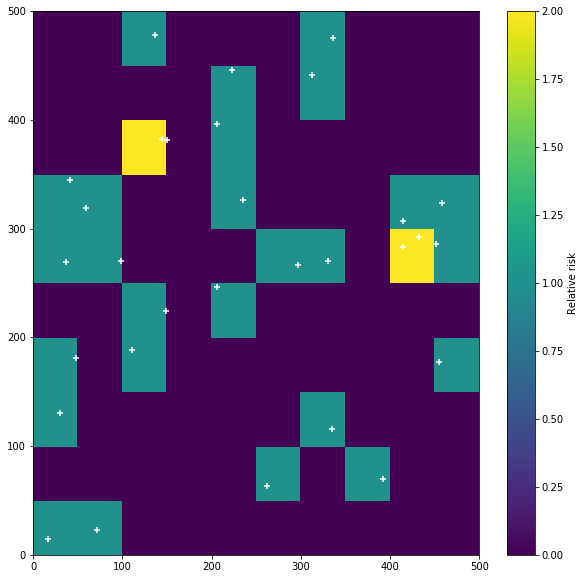

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

m = ax.pcolor(*prediction.mesh_data(), prediction.intensity_matrix)
ax.scatter(points.xcoords, points.ycoords, marker="+", color="white")
ax.set(xlim=[0, 500], ylim=[0, 500])
cb = plt.colorbar(m, ax=ax)
cb.set_label("Relative risk")
None

Now we instead use `scipy` Gaussian KDE, so that the predictor is smoothed to use a continuous function still aiming to have the highest values centered at the cells containing the most events.

In [24]:
predictor = naive.ScipyKDE()
predictor.data = points
prediction = predictor.predict()
gridpred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(prediction, region, 50)

width = 10
height = 10
gonna make matrix...
gonna make GridPredictionArray...


Plot the visualization

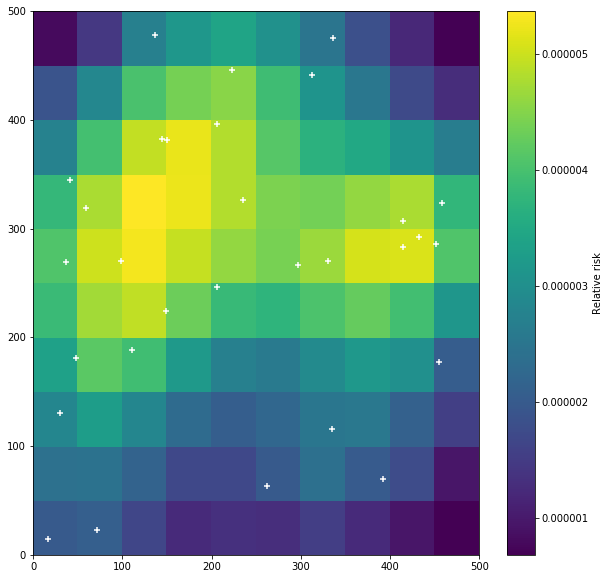

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

m = ax.pcolor(*gridpred.mesh_data(), gridpred.intensity_matrix)
ax.scatter(points.xcoords, points.ycoords, marker="+", color="white")
ax.set(xlim=[0, 500], ylim=[0, 500])
cb = plt.colorbar(m, ax=ax)
cb.set_label("Relative risk")
None

Challenge to myself: Can I figure out a way to repeat the above experiment, but with a 2D normal distribution for the data I generate instead?

In [26]:
"""

def measure(n):
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1 + m2, m1 - m2

def actual_kernel(point):
    x, y = point[0], point[1]
    # m2 = 0.5 * np.random.normal
    # Transform matrix is: A = 1  1/2
    #                          1 -1/2
    # So covariance matrix is AA^* = 5/4  3/4
    #                                3/4  5/4
    a = x * (5 * x - 3 * y) / 4 + y * (-3 * x + 5 * y) / 4
    return np.exp(-a/2) / 2*np.pi

m1, m2 = measure(2000)
xmin, xmax = min(m1), max(m1)
ymin, ymax = min(m2), max(m2)

data_2d = np.vstack([m1, m2])
kernel_2d = scipy.stats.gaussian_kde(data_2d)




X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel_2d(positions).T, X.shape)
Z_actual = np.reshape(actual_kernel(positions).T, X.shape)

fig, ax = plt.subplots(ncols=3, figsize=(16,10))

for i, z in enumerate([Z, Z, Z_actual]):
    ax[i].imshow(np.rot90(z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
    ax[i].set_aspect(1)
ax[0].plot(m1, m2, 'k.', markersize=2, alpha=0.3)
ax[0].set_title("Estimated kernel and data")
ax[1].set_title("Estimated kernel")
ax[2].set_title("Actual kernel")
None

"""


'\n\ndef measure(n):\n    m1 = np.random.normal(size=n)\n    m2 = np.random.normal(scale=0.5, size=n)\n    return m1 + m2, m1 - m2\n\ndef actual_kernel(point):\n    x, y = point[0], point[1]\n    # m2 = 0.5 * np.random.normal\n    # Transform matrix is: A = 1  1/2\n    #                          1 -1/2\n    # So covariance matrix is AA^* = 5/4  3/4\n    #                                3/4  5/4\n    a = x * (5 * x - 3 * y) / 4 + y * (-3 * x + 5 * y) / 4\n    return np.exp(-a/2) / 2*np.pi\n\nm1, m2 = measure(2000)\nxmin, xmax = min(m1), max(m1)\nymin, ymax = min(m2), max(m2)\n\ndata_2d = np.vstack([m1, m2])\nkernel_2d = scipy.stats.gaussian_kde(data_2d)\n\n\n\n\nX, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]\npositions = np.vstack([X.ravel(), Y.ravel()])\nZ = np.reshape(kernel_2d(positions).T, X.shape)\nZ_actual = np.reshape(actual_kernel(positions).T, X.shape)\n\nfig, ax = plt.subplots(ncols=3, figsize=(16,10))\n\nfor i, z in enumerate([Z, Z, Z_actual]):\n    ax[i].imshow(np.rot90(z),

Let's try to do that same naive algorithm from the top, but using UK data instead of random data.

In [27]:
# Obtain UK data

import open_cp.sources.ukpolice as ukpolice
print(inspect.getfile(ukpolice))
points = ukpolice.default_burglary_data()
len(points.timestamps)

C:\Users\Dustin\Documents\GitHub\PredictCode\open_cp\sources\ukpolice.py


2358

RectangularRegion( (390838.65061379,406517.12607389205) -> (450375.10976684024,449437.1737942364) )
<class 'open_cp.data.RectangularRegion'>


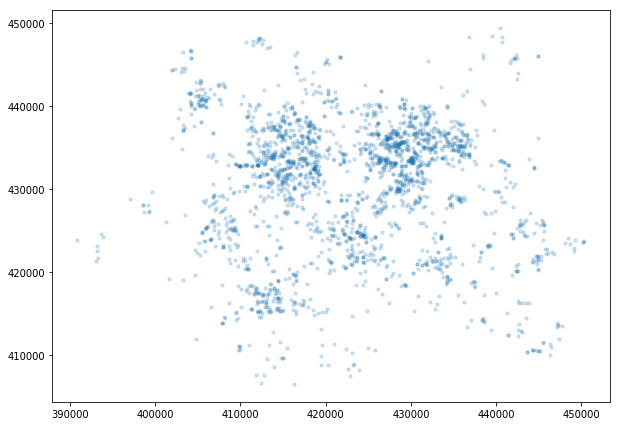

In [28]:
# Use pyproj to make a more properly projected visualization of the data
projected_points = open_cp.data.points_from_lon_lat(points, epsg=7405)
points = projected_points
bbox = points.bounding_box
fig, ax = plt.subplots(figsize=(10, 10 * bbox.aspect_ratio))
ax.scatter(points.xcoords, points.ycoords, s=10, alpha=0.2)
print(bbox)
print(type(bbox))

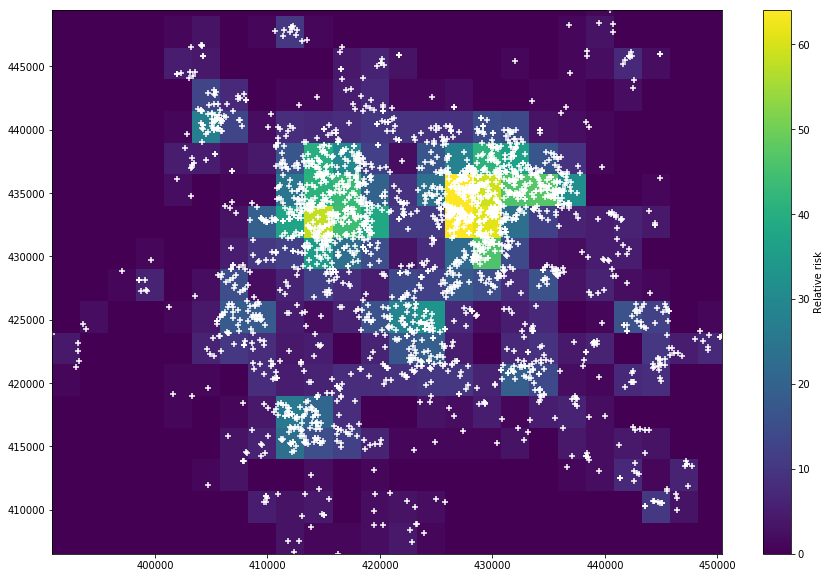

In [61]:
region = open_cp.RectangularRegion(np.floor(bbox.xmin), np.ceil(bbox.xmax), np.floor(bbox.ymin), np.ceil(bbox.ymax))
predictor = naive.CountingGridKernel(2500, region=region)
predictor.data = points
prediction = predictor.predict()

# Plot the figure, 15in x 10in image
fig, ax = plt.subplots(figsize=(15,10))

m = ax.pcolor(*prediction.mesh_data(), prediction.intensity_matrix)
ax.scatter(points.xcoords, points.ycoords, marker="+", color="white")
ax.set(xlim=[bbox.xmin, bbox.xmax], ylim=[bbox.ymin, bbox.ymax])
cb = plt.colorbar(m, ax=ax)
cb.set_label("Relative risk")
None

In [75]:
importlib.reload(open_cp.predictors)

predictor = naive.ScipyKDE()
predictor.data = points
prediction = predictor.predict()

print(type(prediction))
print(prediction)

print(region.height)
print(region.width)
print(region.grid_size)

print(prediction.samples)
gridpred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(prediction, region, 2500)
print("Finished making gridpred!!!")
#gridpred

#newpred = prediction.rebase(cell_width=2500, cell_height=2500, xoffset=bbox.xmin, yoffset=bbox.ymin, samples=25)


<class 'open_cp.predictors.KernelRiskPredictor'>
42921.0
59538.0
<bound method RectangularRegion.grid_size of RectangularRegion( (390838.0,406517.0) -> (450376.0,449438.0) )>
12
width = 24
height = 17
prediction.samples :
12
Calling prediction.rebase
.
Rebase-ing...
12
12
None
{'cell_width': 50, 'cell_height': 50, 'xoffset': 0, 'yoffset': 0, '_ContinuousPrediction__samples': None, '_samples': 12, '_kernel': <scipy.stats.kde.gaussian_kde object at 0x000001B9DB843E80>}
Inside rebase, samples = 12
blah blah
Done with prediction.rebase
newpred.xoffset :
390838.0
newpred.yoffset :
406517.0
newpred.samples :
12
Inside from_continuous_prediction
gonna make matrix...
width and height :
24
17
prediction.samples :
12
Calling prediction.to_matrix(width,height)
12
2500
2500
6250000
2400
finished to_matrix
gonna make GridPredictionArray...
Finished making gridpred!!!


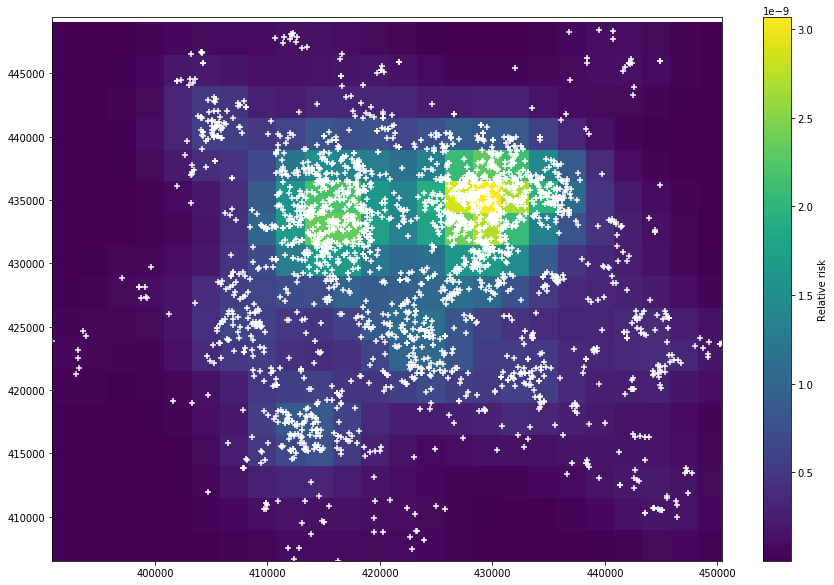

In [76]:
fig, ax = plt.subplots(figsize=(15,10))

m = ax.pcolor(*gridpred.mesh_data(), gridpred.intensity_matrix)
ax.scatter(points.xcoords, points.ycoords, marker="+", color="white")
ax.set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
cb = plt.colorbar(m, ax=ax)
cb.set_label("Relative risk")
None
